In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from pearce.emulator.emu import OriginalRecipe, ExtraCrispy
from pearce.emulator.trainingData import parameter, PARAMS

In [41]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [42]:
training_dir = '/u/ki/swmclau2/des/Pearce_wp_LHC'
fiducial_params = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02,
                      'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints = (rbins[1:]+rbins[:-1])/2

In [43]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [44]:
y_param_idx = -1
for idx, p in enumerate(PARAMS):
    if p.name==y_param:
        y_param_idx = idx
        break
        
y_vals = np.linspace(PARAMS[y_param_idx].low, PARAMS[y_param_idx].high, 4)
em_params[y_param] = y_vals

In [45]:
print em_params[y_param]

[ 11.7         11.96666667  12.23333333  12.5       ]


In [46]:
print len(em_params)

6


In [47]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu1 = OriginalRecipe(training_dir,or_params)

In [48]:
rpoints = np.logspace(np.log10(rbins[0]), np.log10(rbins[-1]), 200)
log_xi_pred, log_xi_cov = emu1.emulate_wrt_r(em_params, rpoints)
log_xi_err = np.sqrt(np.diag(log_xi_cov))
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = log_xi_err.reshape((-1, len(rpoints)))

In [49]:
truth_dir = '/u/ki/swmclau2/des/Pearce_wp_FHC/'
plot_r, plot_xi, plot_xi_err = emu1.get_plot_data(em_params,truth_dir, independent_variable=None)

(4, 6)


In [50]:
plot_xi.shape, plot_r.shape, plot_xi_err.shape

((4, 17), (4, 17), (4, 17))

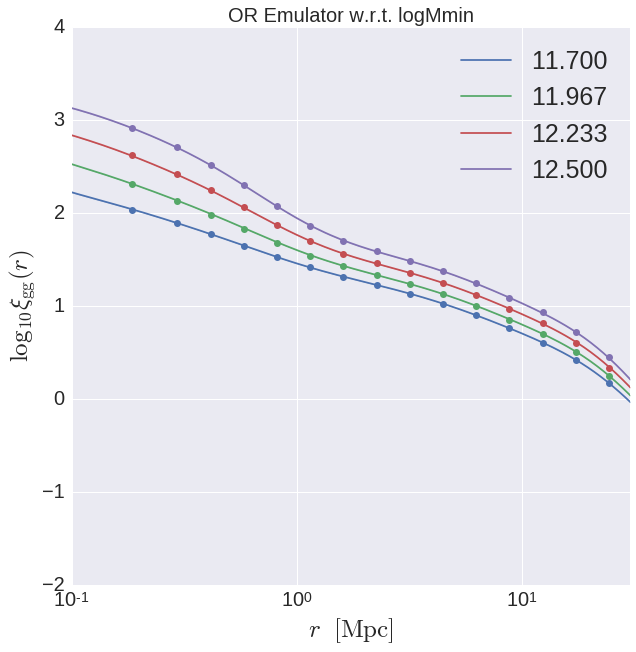

In [51]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [52]:
emu2 = ExtraCrispy(training_dir)#no r in params

In [53]:
rpoints = np.logspace(np.log10(emu2.bin_centers[1]), np.log10(emu2.bin_centers[-2]), 200)

In [54]:
log_xi_pred, log_xi_cov = emu2.emulate_wrt_r(em_params,rpoints)
log_xi_err = np.sqrt(np.diag(log_xi_cov))
#print log_xi_pred
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = log_xi_err.reshape((-1, len(rpoints)))

In [55]:
print log_xi_pred[:,0]
print plot_xi[:,0]

[ 2.03155454  2.31885813  2.62153691  2.90679433]
[ 2.22834528  2.54148836  2.8554588   3.14435658]


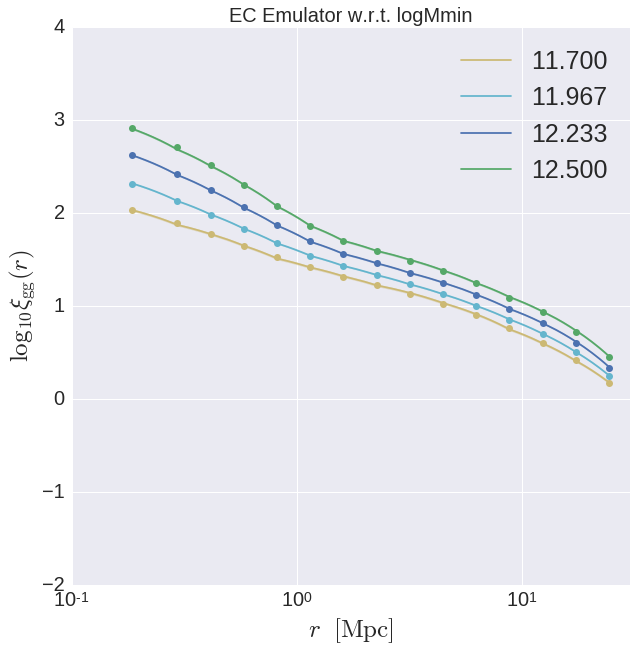

In [56]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("EC Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [57]:
from os import path

In [58]:
save_dir = '/u/ki/swmclau2/des/EmulatorMCMC/'
true_rpoints = np.log10(np.loadtxt(path.join(save_dir, 'rpoints.npy')))
y = np.loadtxt(path.join(save_dir, 'xi.npy'))
cov = np.loadtxt(path.join(save_dir, 'cov.npy'))
true_cov = cov/(np.outer(y,y)*np.log(10)**2)
#T = np.diag(np.diag(T))
true_y = np.log10(y)

In [59]:
import emcee as mc
from itertools import izip
nwalkers = 100
n_cores = 2
nsteps = 10
nburn = 1

In [60]:
from pearce.emulator.emu import lnprob as lnprob2